In [1]:
import pandas as pd
import os

In [2]:
def preprocess_participant_file(file_path, participant_id):
    # Read the CSV file using the passed file_path
    df = pd.read_csv(file_path)
    
    # Get AU columns (assuming they start with 'AU')
    au_columns = [col for col in df.columns if col.startswith('AU')]
    
    # Ensure 'label' and 'counter' columns exist
    required_columns = au_columns + ['label', 'counter']
    missing_columns = [col for col in required_columns if col not in df.columns]
    if missing_columns:
        raise ValueError(f"The following required columns are missing in {file_path}: {missing_columns}")
    
    # Keep only AUs, 'label', and 'counter'
    df_cleaned = df[required_columns]
    
    # Add participant ID
    df_cleaned['participant_id'] = participant_id
    
    return df_cleaned

# List of your specific files
participant_files = [
    'daffa_test_1_preprocessed.csv',
    'jeihan_test_1_preprocessed.csv',
    'theo_test_1_preprocessed.csv',
    'toby_test_1_preprocessed.csv',
    'yuuki_test_2_preprocessed.csv'
]

# Process all participants
all_participants = []

for participant_id, file_name in enumerate(participant_files, 1):
    file_path = os.path.join('Preprocessed', file_name)
    print(f"Processing participant {participant_id}: {file_name}")
    
    try:
        participant_data = preprocess_participant_file(file_path, participant_id)
        all_participants.append(participant_data)
    except Exception as e:
        print(f"Error processing {file_name}: {e}")

# Check if any participant data was processed
if all_participants:
    # Combine all participant data
    combined_df = pd.concat(all_participants, ignore_index=True)
    
    # Save combined dataset
    output_path = os.path.join('Preprocessed', 'combined_participant_data.csv')
    combined_df.to_csv(output_path, index=False)
    
    print(f"\nCombined dataset saved to: {output_path}")
    print(f"Total number of participants: {len(participant_files)}")
    print(f"Total number of rows: {len(combined_df)}")
else:
    print("No participant data was processed.")


Processing participant 1: daffa_test_1_preprocessed.csv
Processing participant 2: jeihan_test_1_preprocessed.csv
Processing participant 3: theo_test_1_preprocessed.csv
Processing participant 4: toby_test_1_preprocessed.csv
Processing participant 5: yuuki_test_2_preprocessed.csv

Combined dataset saved to: Preprocessed/combined_participant_data.csv
Total number of participants: 5
Total number of rows: 7320


/var/folders/7x/jtyhzd_14j9ffl7xdn6p0vnw0000gn/T/ipykernel_68028/1599509128.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['participant_id'] = participant_id
/var/folders/7x/jtyhzd_14j9ffl7xdn6p0vnw0000gn/T/ipykernel_68028/1599509128.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['participant_id'] = participant_id
/var/folders/7x/jtyhzd_14j9ffl7xdn6p0vnw0000gn/T/ipykernel_68028/1599509128.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

In [3]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import random

# Set random seeds for reproducibility
def set_seeds(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

set_seeds()

def create_model(input_dim, output_dim):
    """
    Create and compile a Keras Sequential model with the original Dense layer architecture.
    
    Parameters:
    - input_dim (int): Number of input features.
    - output_dim (int): Number of output classes.
    
    Returns:
    - model (Sequential): Compiled Keras model.
    """
    model = Sequential([
        Dense(24, activation='relu', input_dim=input_dim),
        Dense(24, activation='relu'),
        Dense(12, activation='relu'),
        Dense(output_dim, activation='softmax')
    ])
    model.compile(
        optimizer='adam',  # Changed to 'adam' for broader compatibility
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Load the combined dataset
df = pd.read_csv("Preprocessed/combined_participant_data.csv")

# Define the specific AU columns as provided
au_columns = [
    'AU01_r', 'AU02_r', 'AU04_r', 'AU05_r', 'AU06_r', 'AU07_r',
    'AU09_r', 'AU10_r', 'AU12_r', 'AU14_r', 'AU15_r', 'AU17_r',
    'AU20_r', 'AU23_r', 'AU25_r', 'AU26_r', 'AU45_r'
]

# Verify the required columns are present
required_columns = au_columns + ['label', 'counter', 'participant_id']
missing_columns = [col for col in required_columns if col not in df.columns]
if missing_columns:
    raise ValueError(f"The following required columns are missing in the dataset: {missing_columns}")

# Extract features and labels
X = df[au_columns].values
y = df[['label']]  # Keep as DataFrame for OneHotEncoder
participant_ids = df['participant_id'].values

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# One-Hot Encode Labels
encoder = OneHotEncoder(sparse_output=False)
y_one_hot = encoder.fit_transform(y)
num_classes = y_one_hot.shape[1]
class_labels = encoder.categories_[0]
print(f"Classes: {class_labels}")

# Initialize metrics storage
metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1-score': []
}

# Perform Participant-Based LOOCV
unique_participants = np.unique(participant_ids)
for participant in unique_participants:
    print(f"\nTesting on Participant {participant}")
    
    # Split data by participant ID
    test_mask = (participant_ids == participant)
    X_train, X_test = X_scaled[~test_mask], X_scaled[test_mask]
    y_train, y_test = y_one_hot[~test_mask], y_one_hot[test_mask]
    
    # Convert one-hot labels back to integer indices for classification report
    y_test_int = np.argmax(y_test, axis=1)
    y_train_int = np.argmax(y_train, axis=1)
    
    # Check if all classes are present in training data
    unique_classes = np.unique(y_train_int)
    if len(unique_classes) < num_classes:
        print(f"Warning: Participant {participant} training data does not contain all classes.")
    
    # Create and train the model
    model = create_model(input_dim=X_train.shape[1], output_dim=num_classes)
    early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)
    
    history = model.fit(
        X_train, y_train,
        epochs=1000,
        batch_size=256,
        validation_split=0.1,
        callbacks=[early_stop],
        verbose=0  # Set to 1 for detailed logs
    )
    
    # Predict on the test set
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)
    
    # Compute metrics
    acc = accuracy_score(y_test_int, y_pred)
    report = classification_report(y_test_int, y_pred, target_names=class_labels, output_dict=True, zero_division=0)
    
    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    f1 = report['weighted avg']['f1-score']
    
    metrics['accuracy'].append(acc)
    metrics['precision'].append(precision)
    metrics['recall'].append(recall)
    metrics['f1-score'].append(f1)
    
    # Detailed per-class metrics
    print(f"Participant {participant} Results:")
    print(classification_report(y_test_int, y_pred, target_names=class_labels, zero_division=0))
    print(f"Accuracy:  {acc:.4f}")
    
# Aggregate and display average metrics
print("\nAverage Results Across All Participants:")
print(f"Accuracy:  {np.mean(metrics['accuracy']):.4f} ± {np.std(metrics['accuracy']):.4f}")
print(f"Precision: {np.mean(metrics['precision']):.4f} ± {np.std(metrics['precision']):.4f}")
print(f"Recall:    {np.mean(metrics['recall']):.4f} ± {np.std(metrics['recall']):.4f}")
print(f"F1 Score:  {np.mean(metrics['f1-score']):.4f} ± {np.std(metrics['f1-score']):.4f}")


Classes: ["I don't need anything right now" 'I need an easier quesiton'
 'I need feedback on my progress' 'I need reminders to stay focused'
 'I need to take a break']

Testing on Participant 1


/Users/neptune/anaconda3/envs/AI2023/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 26: early stopping
Restoring model weights from the end of the best epoch: 6.
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Participant 1 Results:
                                  precision    recall  f1-score   support

 I don't need anything right now       0.00      0.00      0.00         0
       I need an easier quesiton       0.60      0.01      0.01       600
  I need feedback on my progress       0.00      0.00      0.00         0
I need reminders to stay focused       0.72      0.05      0.09       281
          I need to take a break       0.00      0.00      0.00         0

                        accuracy                           0.02       881
                       macro avg       0.26      0.01      0.02       881
                    weighted avg       0.64      0.02      0.03       881

Accuracy:  0.0182

Testing on Participant 2


/Users/neptune/anaconda3/envs/AI2023/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 25: early stopping
Restoring model weights from the end of the best epoch: 5.
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
Participant 2 Results:
                                  precision    recall  f1-score   support

 I don't need anything right now       0.52      0.69      0.59       900
       I need an easier quesiton       0.02      0.02      0.02       300
  I need feedback on my progress       0.71      0.04      0.08       900
I need reminders to stay focused       0.00      0.00      0.00         0
          I need to take a break       0.00      0.00      0.00         0

                        accuracy                           0.31      2100
                       macro avg       0.25      0.15      0.14      2100
                    weighted avg       0.53      0.31      0.29      2100

Accuracy:  0.3143

Testing on Participant 3


/Users/neptune/anaconda3/envs/AI2023/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 29: early stopping
Restoring model weights from the end of the best epoch: 9.
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Participant 3 Results:
                                  precision    recall  f1-score   support

 I don't need anything right now       0.00      0.00      0.00         0
       I need an easier quesiton       0.00      0.00      0.00         0
  I need feedback on my progress       0.00      0.00      0.00         0
I need reminders to stay focused       0.24      0.10      0.14       300
          I need to take a break       0.43      0.46      0.44       300

                        accuracy                           0.28       600
                       macro avg       0.13      0.11      0.12       600
                    weighted avg       0.33      0.28      0.29       600

Accuracy:  0.2800

Testing on Participant 4


/Users/neptune/anaconda3/envs/AI2023/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 21: early stopping
Restoring model weights from the end of the best epoch: 1.
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step
Participant 4 Results:
                                  precision    recall  f1-score   support

 I don't need anything right now       0.72      0.08      0.15      1500
       I need an easier quesiton       0.04      0.20      0.07       300
  I need feedback on my progress       0.53      0.27      0.36       600
I need reminders to stay focused       0.22      0.07      0.11       300
          I need to take a break       0.00      0.00      0.00         0

                        accuracy                           0.14      2700
                       macro avg       0.30      0.12      0.14      2700
                    weighted avg       0.55      0.14      0.18      2700

Accuracy:  0.1352

Testing on Participant 5


/Users/neptune/anaconda3/envs/AI2023/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 21: early stopping
Restoring model weights from the end of the best epoch: 1.
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
Participant 5 Results:
                                  precision    recall  f1-score   support

 I don't need anything right now       0.29      0.75      0.41       300
       I need an easier quesiton       0.00      0.00      0.00         0
  I need feedback on my progress       0.00      0.00      0.00         0
I need reminders to stay focused       0.00      0.00      0.00       139
          I need to take a break       0.00      0.00      0.00       600

                        accuracy                           0.22      1039
                       macro avg       0.06      0.15      0.08      1039
                    weighted avg       0.08      0.22      0.12      1039

Accuracy:  0.2175

Average Results Across All Participants:
Accuracy:  0.1930 ± 0.1066
Precision: 0.4259 ± 0.1988
Recall:    0.1930 ± 0.1066
F1 Score:  0.1828 ± 0.0990


In [4]:
# Load the dataset
df = pd.read_csv("Preprocessed/combined_participant_data.csv")

# Define the specific AU columns
au_columns = [
    'AU01_r', 'AU02_r', 'AU04_r', 'AU05_r', 'AU06_r', 'AU07_r',
    'AU09_r', 'AU10_r', 'AU12_r', 'AU14_r', 'AU15_r', 'AU17_r',
    'AU20_r', 'AU23_r', 'AU25_r', 'AU26_r', 'AU45_r'
]

# Extract labels and participant IDs
labels = df['label']
participants = df['participant_id']

# Create a DataFrame for easier manipulation
distribution_df = pd.crosstab(participants, labels)

print(distribution_df)


label           I don't need anything right now  I need an easier quesiton  \
participant_id                                                               
1                                             0                        600   
2                                           900                        300   
3                                             0                          0   
4                                          1500                        300   
5                                           300                          0   

label           I need feedback on my progress  \
participant_id                                   
1                                            0   
2                                          900   
3                                            0   
4                                          600   
5                                            0   

label           I need reminders to stay focused  I need to take a break  
participant_id             

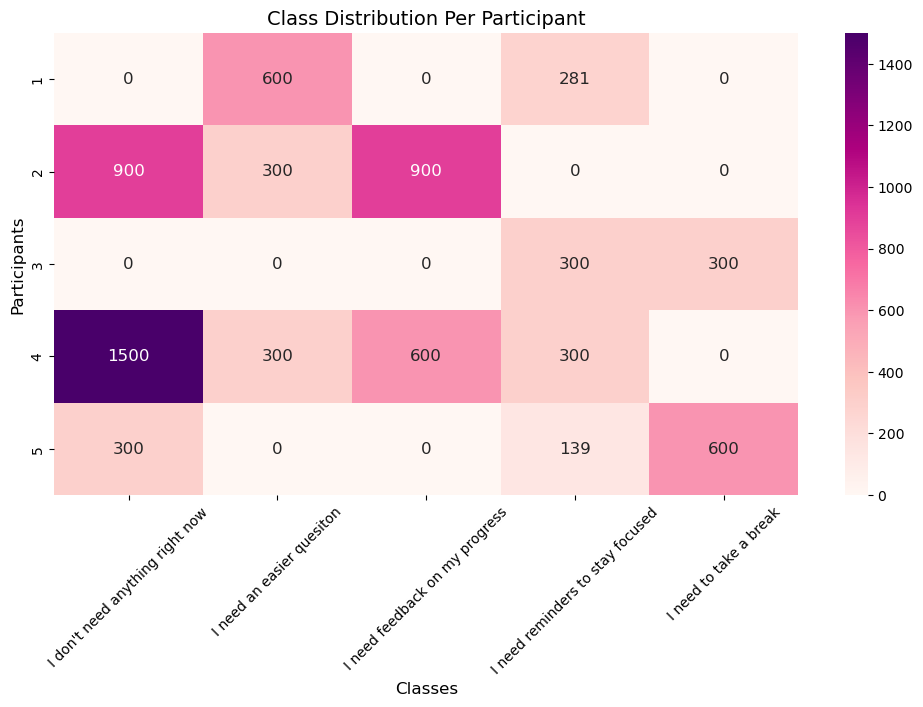

In [11]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Plot heatmap of class distribution
# plt.figure(figsize=(12, 6))
# sns.heatmap(distribution_df, annot=True, fmt="d", cmap="YlGnBu")
# plt.title("Class Distribution Per Participant")
# plt.xlabel("Classes")
# plt.ylabel("Participants")
# plt.show()

import matplotlib.pyplot as plt
import seaborn as sns

# Plot heatmap of class distribution
fig, ax = plt.subplots(figsize=(12, 6))
heatmap = sns.heatmap(
    distribution_df,
    annot=True,
    fmt="d",
    cmap="RdPu",  # Matches the "RdPu" colormap
    annot_kws={"size": 12},  # Customize annotation font size
    ax=ax
)

# Customize labels and ticks
heatmap.set_title("Class Distribution Per Participant", fontsize=14)
heatmap.set_xlabel("Classes", fontsize=12)
heatmap.set_ylabel("Participants", fontsize=12)
plt.xticks(rotation=45)  # Rotate x-ticks to match the confusion matrix style

plt.show()

Classes: ["I don't need anything right now" 'I need an easier quesiton'
 'I need feedback on my progress' 'I need reminders to stay focused'
 'I need to take a break']

Testing on Participant 1
Applied SMOTE to balance classes.
Epoch 358: early stopping
Restoring model weights from the end of the best epoch: 338.
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Participant 1 Results:
                                  precision    recall  f1-score   support

 I don't need anything right now       0.00      0.00      0.00         0
       I need an easier quesiton       0.97      0.05      0.09       600
  I need feedback on my progress       0.00      0.00      0.00         0
I need reminders to stay focused       0.83      0.11      0.19       281
          I need to take a break       0.00      0.00      0.00         0

                        accuracy                           0.07       881
                       macro avg       0.36      0.03      0.06       881
                    weighted

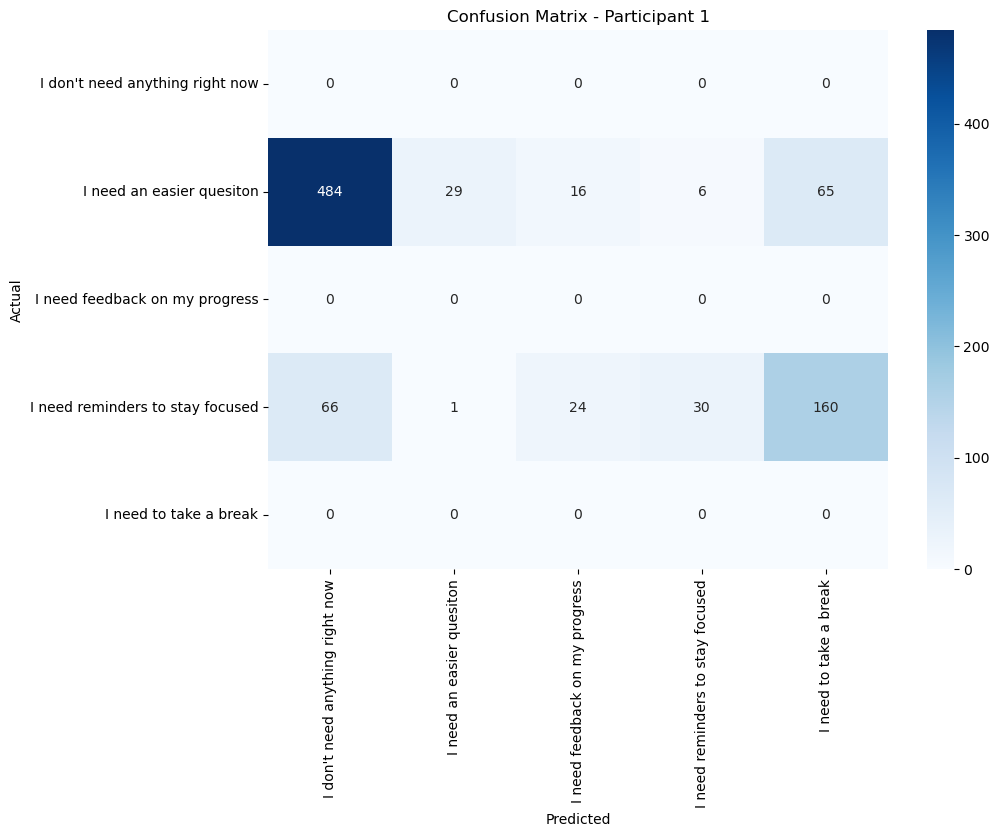


Testing on Participant 2
Applied SMOTE to balance classes.
Epoch 241: early stopping
Restoring model weights from the end of the best epoch: 221.
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step
Participant 2 Results:
                                  precision    recall  f1-score   support

 I don't need anything right now       0.48      0.64      0.55       900
       I need an easier quesiton       0.03      0.01      0.01       300
  I need feedback on my progress       0.55      0.07      0.13       900
I need reminders to stay focused       0.00      0.00      0.00         0
          I need to take a break       0.00      0.00      0.00         0

                        accuracy                           0.31      2100
                       macro avg       0.21      0.14      0.14      2100
                    weighted avg       0.45      0.31      0.29      2100

Accuracy:  0.3076


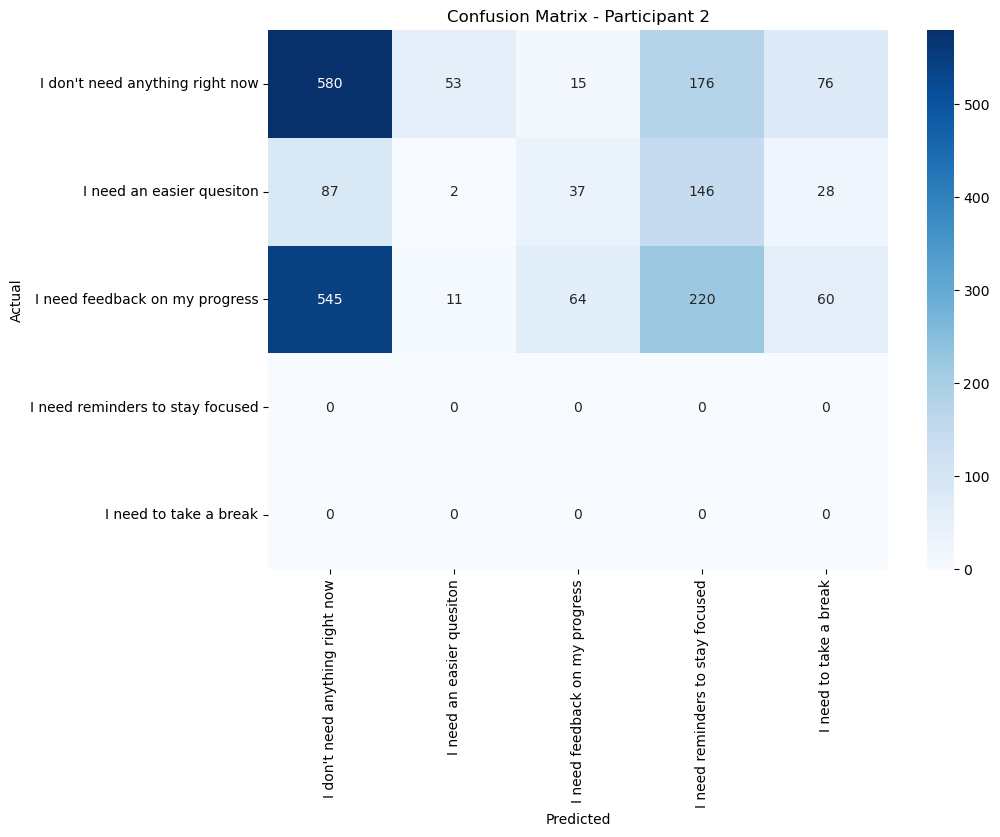


Testing on Participant 3
Applied SMOTE to balance classes.
Epoch 352: early stopping
Restoring model weights from the end of the best epoch: 332.
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Participant 3 Results:
                                  precision    recall  f1-score   support

 I don't need anything right now       0.00      0.00      0.00         0
       I need an easier quesiton       0.00      0.00      0.00         0
  I need feedback on my progress       0.00      0.00      0.00         0
I need reminders to stay focused       0.67      0.07      0.12       300
          I need to take a break       0.52      0.48      0.50       300

                        accuracy                           0.27       600
                       macro avg       0.24      0.11      0.12       600
                    weighted avg       0.59      0.27      0.31       600

Accuracy:  0.2717


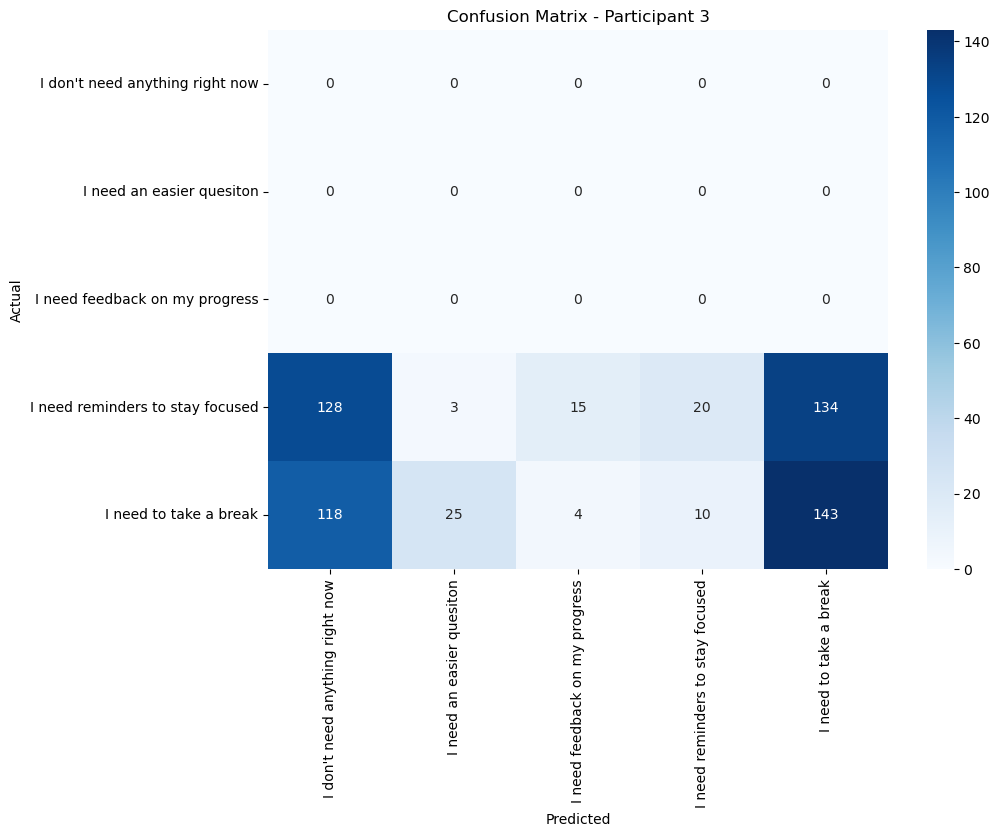


Testing on Participant 4
Applied SMOTE to balance classes.
Epoch 565: early stopping
Restoring model weights from the end of the best epoch: 545.
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step
Participant 4 Results:
                                  precision    recall  f1-score   support

 I don't need anything right now       0.28      0.04      0.06      1500
       I need an easier quesiton       0.02      0.06      0.03       300
  I need feedback on my progress       0.25      0.49      0.33       600
I need reminders to stay focused       0.00      0.00      0.00       300
          I need to take a break       0.00      0.00      0.00         0

                        accuracy                           0.14      2700
                       macro avg       0.11      0.12      0.08      2700
                    weighted avg       0.21      0.14      0.11      2700

Accuracy:  0.1352


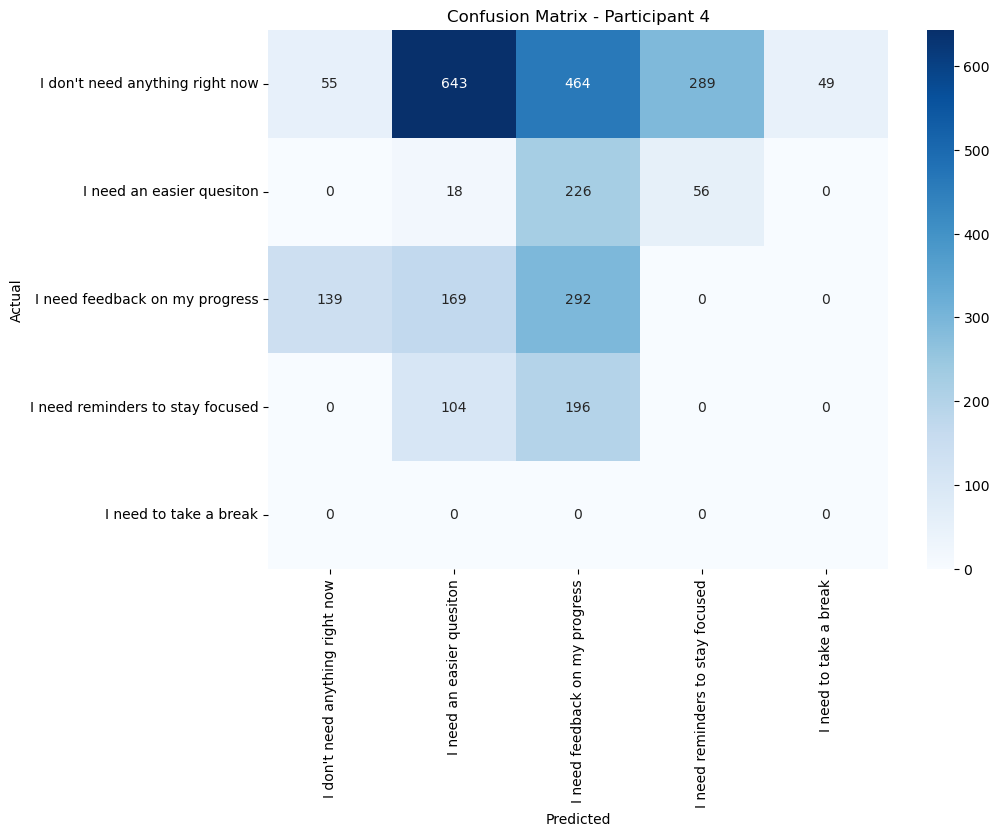


Testing on Participant 5
Applied SMOTE to balance classes.
Epoch 193: early stopping
Restoring model weights from the end of the best epoch: 173.
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Participant 5 Results:
                                  precision    recall  f1-score   support

 I don't need anything right now       0.34      0.24      0.28       300
       I need an easier quesiton       0.00      0.00      0.00         0
  I need feedback on my progress       0.00      0.00      0.00         0
I need reminders to stay focused       0.10      0.40      0.15       139
          I need to take a break       0.73      0.07      0.13       600

                        accuracy                           0.17      1039
                       macro avg       0.23      0.14      0.11      1039
                    weighted avg       0.54      0.17      0.18      1039

Accuracy:  0.1665


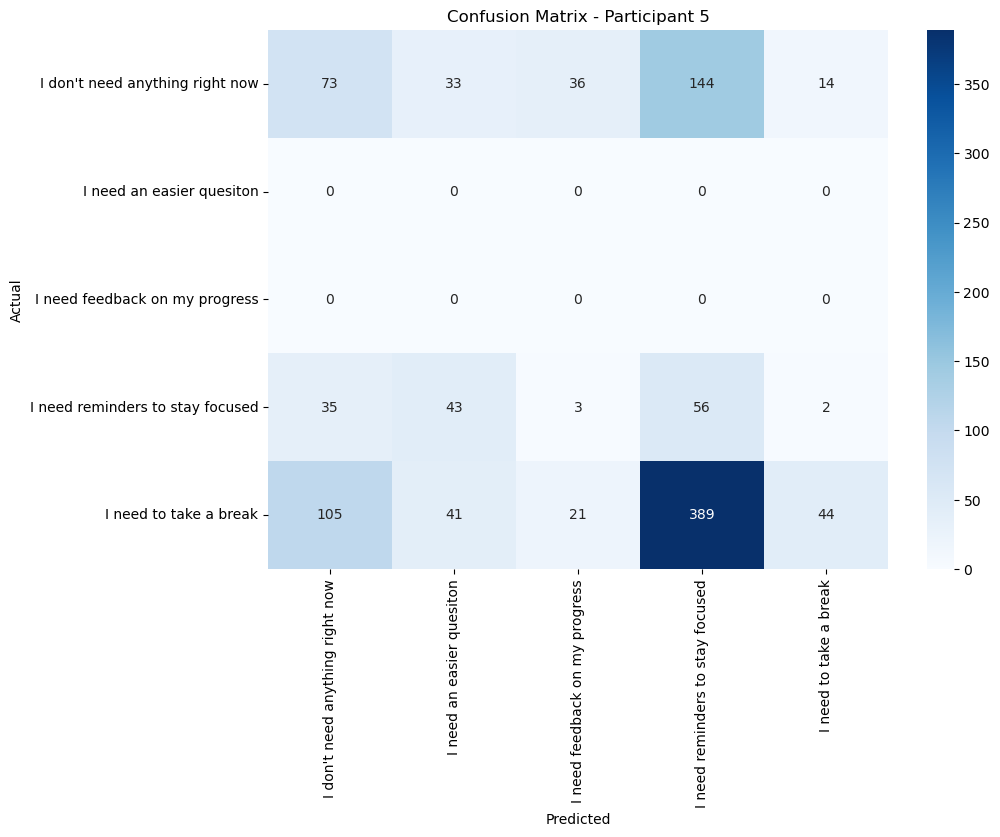


Average Results Across All Participants:
Accuracy:  0.1896 ± 0.0885
Precision: 0.5423 ± 0.2302
Recall:    0.1896 ± 0.0885
F1 Score:  0.2029 ± 0.0825


In [8]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.utils import class_weight  # Import class_weight
from sklearn.model_selection import GroupKFold
from imblearn.over_sampling import SMOTE  # Ensure imblearn is installed
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

# Set random seeds for reproducibility
def set_seeds(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

set_seeds()

def create_model(input_dim, output_dim):
    """
    Create and compile a Keras Sequential model with an explicit Input layer.
    
    Parameters:
    - input_dim (int): Number of input features.
    - output_dim (int): Number of output classes.
    
    Returns:
    - model (Sequential): Compiled Keras model.
    """
    model = Sequential([
        Input(shape=(input_dim,)),  # Explicit Input layer
        Dense(24, activation='relu'),
        Dense(24, activation='relu'),
        Dense(12, activation='relu'),
        Dense(output_dim, activation='softmax')
    ])
    model.compile(
        optimizer='adam',  # Changed to 'adam' for broader compatibility
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Load the combined dataset
df = pd.read_csv("Preprocessed/combined_participant_data.csv")

# Define the specific AU columns as provided
au_columns = [
    'AU01_r', 'AU02_r', 'AU04_r', 'AU05_r', 'AU06_r', 'AU07_r',
    'AU09_r', 'AU10_r', 'AU12_r', 'AU14_r', 'AU15_r', 'AU17_r',
    'AU20_r', 'AU23_r', 'AU25_r', 'AU26_r', 'AU45_r'
]

# Verify the required columns are present
required_columns = au_columns + ['label', 'counter', 'participant_id']
missing_columns = [col for col in required_columns if col not in df.columns]
if missing_columns:
    raise ValueError(f"The following required columns are missing in the dataset: {missing_columns}")

# Extract features and labels
X = df[au_columns].values
y = df[['label']].values  # Keep as 2D array for OneHotEncoder
participant_ids = df['participant_id'].values

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# One-Hot Encode Labels with Version Check
sklearn_version = sklearn.__version__
version_major = int(sklearn_version.split('.')[0])
version_minor = int(sklearn_version.split('.')[1])

if (version_major, version_minor) >= (1, 2):
    encoder = OneHotEncoder(sparse_output=False)
else:
    encoder = OneHotEncoder(sparse=False)

y_one_hot = encoder.fit_transform(y)
num_classes = y_one_hot.shape[1]
class_labels = encoder.categories_[0]
print(f"Classes: {class_labels}")

# Initialize metrics storage
metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1-score': []
}

# Perform Participant-Based LOOCV
unique_participants = np.unique(participant_ids)
for participant in unique_participants:
    print(f"\nTesting on Participant {participant}")
    
    # Split data by participant ID
    test_mask = (participant_ids == participant)
    X_train, X_test = X_scaled[~test_mask], X_scaled[test_mask]
    y_train, y_test = y_one_hot[~test_mask], y_one_hot[test_mask]
    
    # Convert one-hot labels back to integer indices for classification report
    y_test_int = np.argmax(y_test, axis=1)
    y_train_int = np.argmax(y_train, axis=1)
    
    # Check if all classes are present in training data
    unique_classes = np.unique(y_train_int)
    if len(unique_classes) < num_classes:
        print(f"Warning: Participant {participant} training data does not contain all classes.")
    
    # Apply SMOTE to oversample minority classes
    smote = SMOTE(random_state=42)
    try:
        X_train_res, y_train_res = smote.fit_resample(X_train, y_train_int)
        print("Applied SMOTE to balance classes.")
    except ValueError as e:
        print(f"SMOTE failed: {e}. Proceeding without SMOTE.")
        X_train_res, y_train_res = X_train, y_train_int
    
    # One-Hot Encode the Resampled Labels
    y_train_res_one_hot = tf.keras.utils.to_categorical(y_train_res, num_classes=num_classes)
    
    # Compute class weights
    class_weights_array = class_weight.compute_class_weight(
        'balanced',
        classes=np.unique(y_train_res),
        y=y_train_res
    )
    class_weights_dict = dict(enumerate(class_weights_array))
    
    # Create and train the model
    model = create_model(input_dim=X_train_res.shape[1], output_dim=num_classes)
    early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)
    
    history = model.fit(
        X_train_res, y_train_res_one_hot,
        epochs=1000,
        batch_size=256,
        validation_split=0.1,
        callbacks=[early_stop],
        class_weight=class_weights_dict,
        verbose=0  # Set to 1 for detailed logs
    )
    
    # Predict on the test set
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)
    
    # Compute metrics
    acc = accuracy_score(y_test_int, y_pred)
    report = classification_report(y_test_int, y_pred, target_names=class_labels, output_dict=True, zero_division=0)
    
    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    f1 = report['weighted avg']['f1-score']
    
    metrics['accuracy'].append(acc)
    metrics['precision'].append(precision)
    metrics['recall'].append(recall)
    metrics['f1-score'].append(f1)
    
    # Detailed per-class metrics
    print(f"Participant {participant} Results:")
    print(classification_report(y_test_int, y_pred, target_names=class_labels, zero_division=0))
    print(f"Accuracy:  {acc:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test_int, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
    plt.title(f'Confusion Matrix - Participant {participant}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Aggregate and display average metrics
print("\nAverage Results Across All Participants:")
print(f"Accuracy:  {np.mean(metrics['accuracy']):.4f} ± {np.std(metrics['accuracy']):.4f}")
print(f"Precision: {np.mean(metrics['precision']):.4f} ± {np.std(metrics['precision']):.4f}")
print(f"Recall:    {np.mean(metrics['recall']):.4f} ± {np.std(metrics['recall']):.4f}")
print(f"F1 Score:  {np.mean(metrics['f1-score']):.4f} ± {np.std(metrics['f1-score']):.4f}")



Testing on Participant 1
Applied Random Over-Sampling to balance classes.
Epoch 84: early stopping
Restoring model weights from the end of the best epoch: 64.
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Participant 1 Results:
                                  precision    recall  f1-score   support

 I don't need anything right now       0.00      0.00      0.00         0
       I need an easier quesiton       1.00      0.04      0.08       600
  I need feedback on my progress       0.00      0.00      0.00         0
I need reminders to stay focused       0.66      0.10      0.18       281
          I need to take a break       0.00      0.00      0.00         0

                        accuracy                           0.06       881
                       macro avg       0.33      0.03      0.05       881
                    weighted avg       0.89      0.06      0.11       881

Accuracy:  0.0602


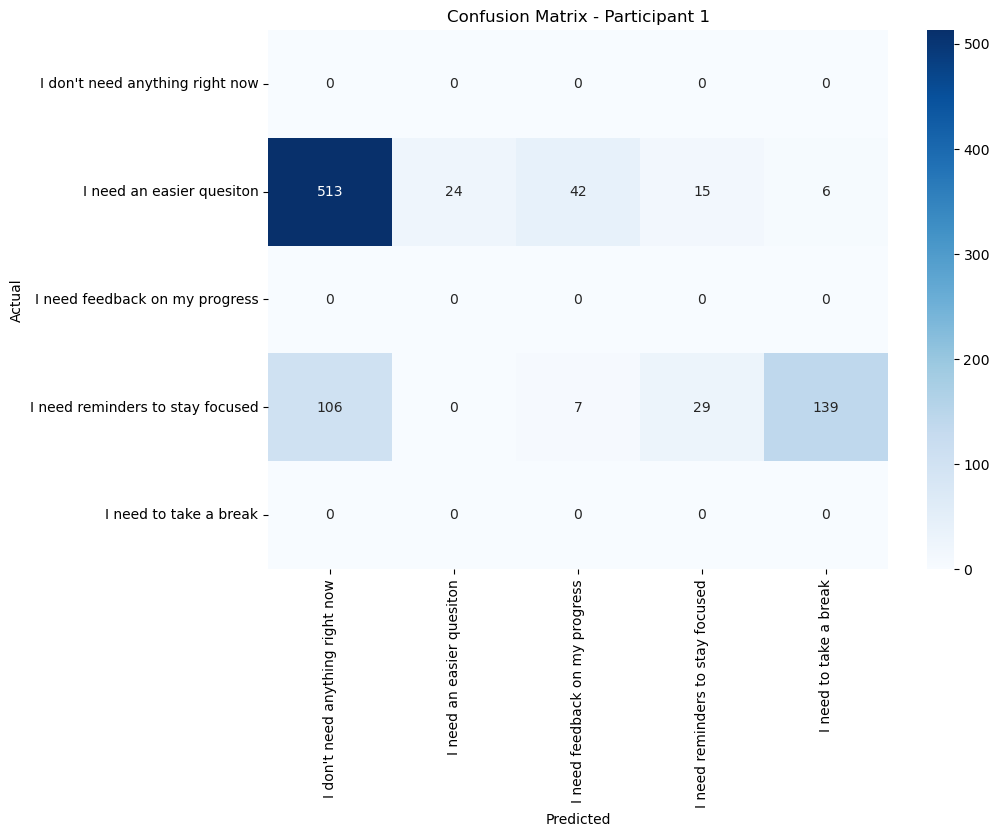


Testing on Participant 2
Applied Random Over-Sampling to balance classes.
Epoch 88: early stopping
Restoring model weights from the end of the best epoch: 68.
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step
Participant 2 Results:
                                  precision    recall  f1-score   support

 I don't need anything right now       0.50      0.75      0.60       900
       I need an easier quesiton       0.08      0.01      0.01       300
  I need feedback on my progress       0.66      0.09      0.16       900
I need reminders to stay focused       0.00      0.00      0.00         0
          I need to take a break       0.00      0.00      0.00         0

                        accuracy                           0.36      2100
                       macro avg       0.25      0.17      0.15      2100
                    weighted avg       0.51      0.36      0.33      2100

Accuracy:  0.3624


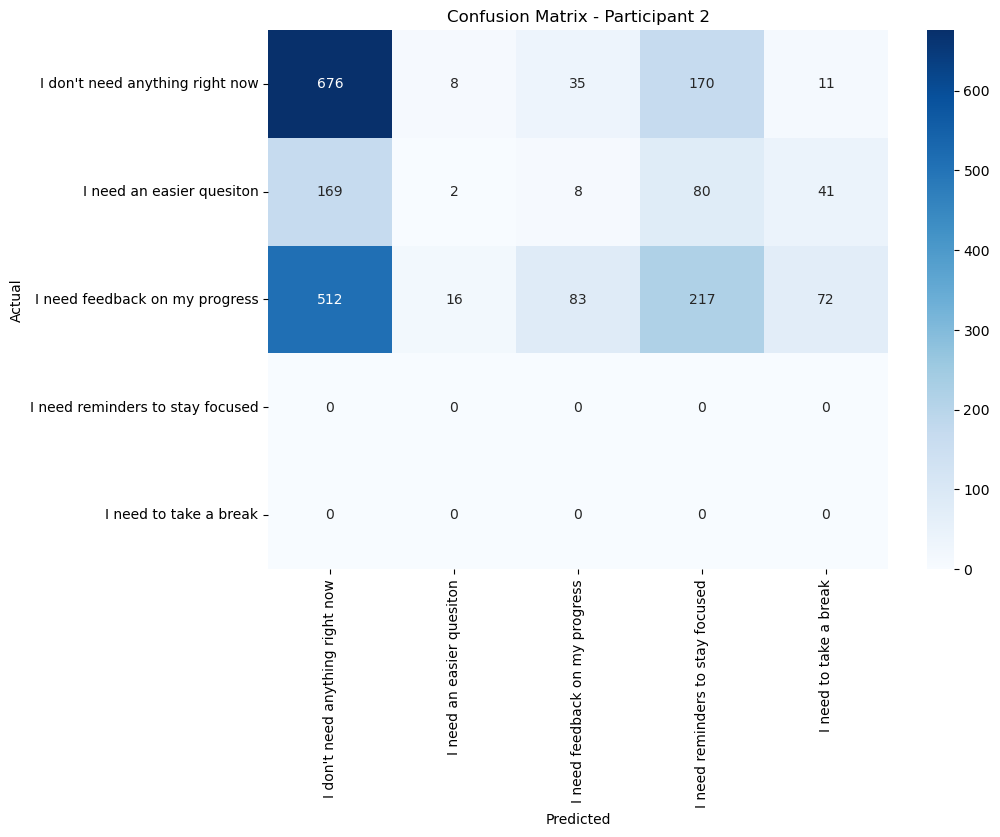


Testing on Participant 3
Applied Random Over-Sampling to balance classes.
Epoch 67: early stopping
Restoring model weights from the end of the best epoch: 47.
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Participant 3 Results:
                                  precision    recall  f1-score   support

 I don't need anything right now       0.00      0.00      0.00         0
       I need an easier quesiton       0.00      0.00      0.00         0
  I need feedback on my progress       0.00      0.00      0.00         0
I need reminders to stay focused       0.37      0.22      0.27       300
          I need to take a break       0.47      0.52      0.49       300

                        accuracy                           0.37       600
                       macro avg       0.17      0.15      0.15       600
                    weighted avg       0.42      0.37      0.38       600

Accuracy:  0.3683


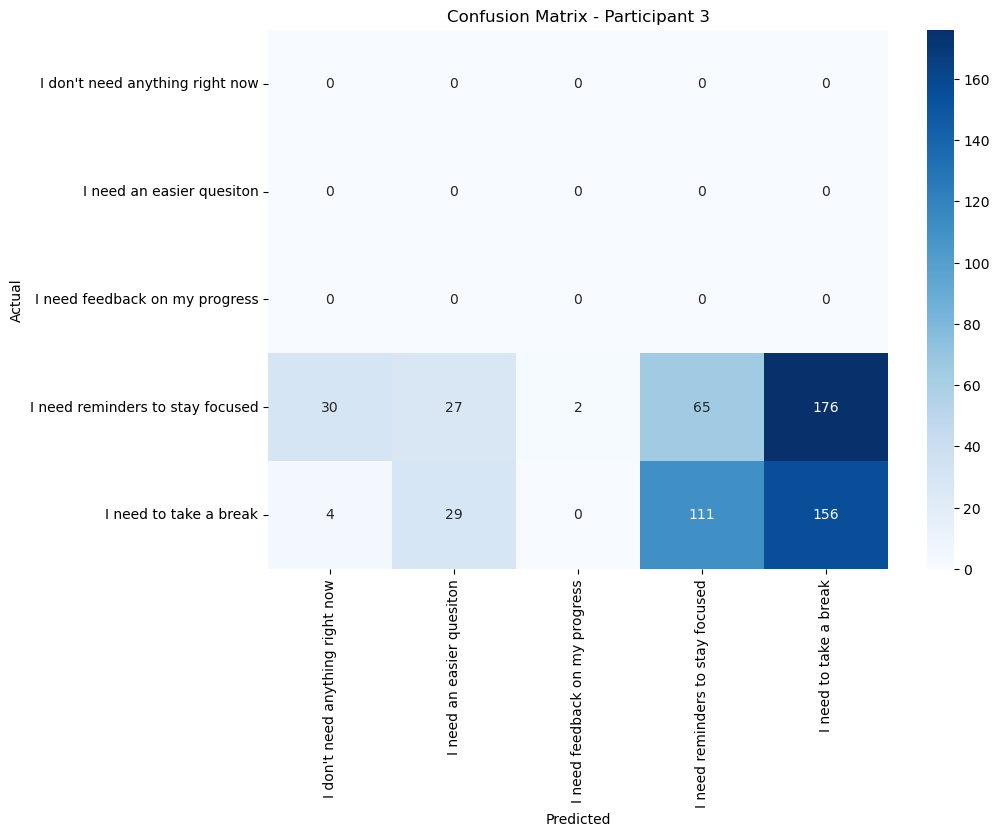


Testing on Participant 4
Applied Random Over-Sampling to balance classes.
Epoch 425: early stopping
Restoring model weights from the end of the best epoch: 405.
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 609us/step
Participant 4 Results:
                                  precision    recall  f1-score   support

 I don't need anything right now       0.99      0.11      0.20      1500
       I need an easier quesiton       0.16      0.34      0.22       300
  I need feedback on my progress       0.36      0.97      0.52       600
I need reminders to stay focused       0.00      0.00      0.00       300
          I need to take a break       0.00      0.00      0.00         0

                        accuracy                           0.32      2700
                       macro avg       0.30      0.28      0.19      2700
                    weighted avg       0.65      0.32      0.25      2700

Accuracy:  0.3156


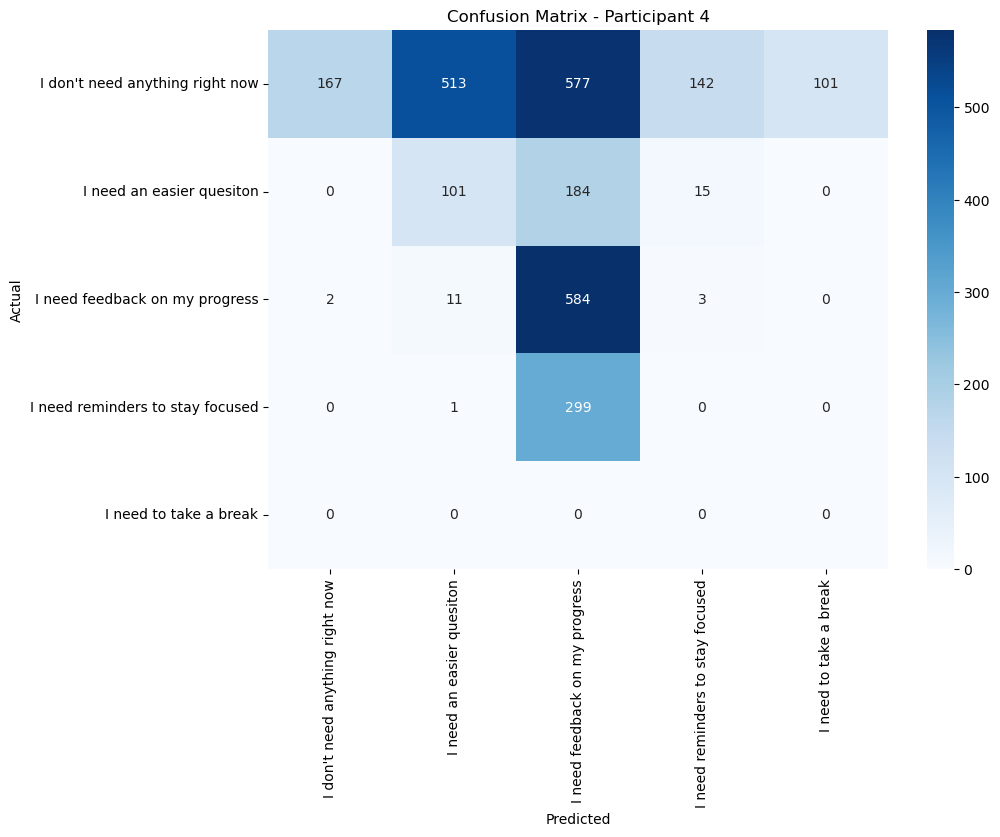


Testing on Participant 5
Applied Random Over-Sampling to balance classes.
Epoch 87: early stopping
Restoring model weights from the end of the best epoch: 67.
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Participant 5 Results:
                                  precision    recall  f1-score   support

 I don't need anything right now       0.44      0.35      0.39       300
       I need an easier quesiton       0.00      0.00      0.00         0
  I need feedback on my progress       0.00      0.00      0.00         0
I need reminders to stay focused       0.14      0.46      0.21       139
          I need to take a break       0.73      0.20      0.32       600

                        accuracy                           0.28      1039
                       macro avg       0.26      0.20      0.18      1039
                    weighted avg       0.57      0.28      0.33      1039

Accuracy:  0.2810


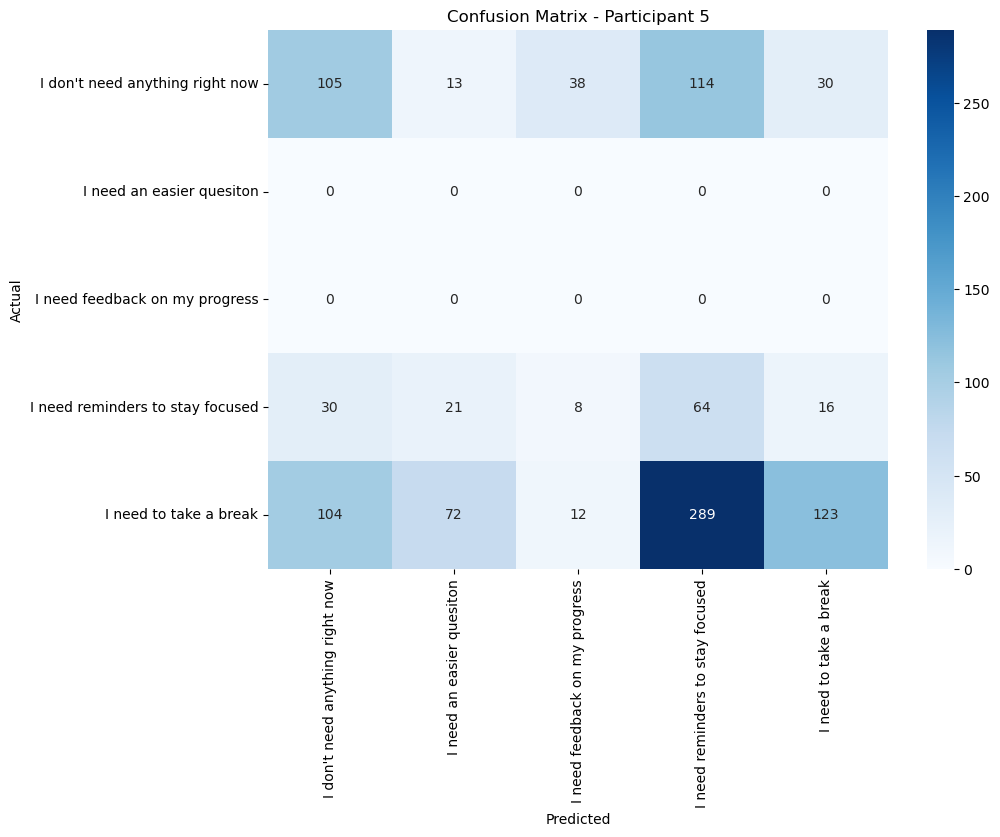

In [9]:
from sklearn.utils import class_weight
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2

unique_participants = np.unique(participant_ids)
for participant in unique_participants:
    print(f"\nTesting on Participant {participant}")
    
    # Split data
    test_mask = (participant_ids == participant)
    X_train, X_test = X_scaled[~test_mask], X_scaled[test_mask]
    y_train, y_test = y_one_hot[~test_mask], y_one_hot[test_mask]
    
    y_test_int = np.argmax(y_test, axis=1)
    y_train_int = np.argmax(y_train, axis=1)
    
    # Check class presence
    unique_classes = np.unique(y_train_int)
    if len(unique_classes) < num_classes:
        print(f"Warning: Participant {participant} training data does not contain all classes.")
    
    # Apply Random Over-Sampling if classes are present
    if len(unique_classes) == num_classes:
        ros = RandomOverSampler(random_state=42)
        X_train_res, y_train_res = ros.fit_resample(X_train, y_train_int)
        print("Applied Random Over-Sampling to balance classes.")
    else:
        print("Random Over-Sampling not applied due to missing classes.")
        X_train_res, y_train_res = X_train, y_train_int
    
    # One-Hot Encode the Resampled Labels
    y_train_res_one_hot = tf.keras.utils.to_categorical(y_train_res, num_classes=num_classes)
    
    # Compute class weights
    if len(unique_classes) == num_classes:
        class_weights_array = class_weight.compute_class_weight(
            'balanced',
            classes=np.unique(y_train_res),
            y=y_train_res
        )
        class_weights_dict = dict(enumerate(class_weights_array))
    else:
        # Assign equal weights if classes are missing
        class_weights_dict = {i: 1.0 for i in range(num_classes)}
    
    # Create and train the model with regularization
    def create_model_with_dropout(input_dim, output_dim):
        model = Sequential([
            Input(shape=(input_dim,)),
            Dense(24, activation='relu', kernel_regularizer=l2(0.001)),
            Dropout(0.5),
            Dense(24, activation='relu', kernel_regularizer=l2(0.001)),
            Dropout(0.5),
            Dense(12, activation='relu', kernel_regularizer=l2(0.001)),
            Dense(output_dim, activation='softmax')
        ])
        model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        return model
    
    model = create_model_with_dropout(input_dim=X_train_res.shape[1], output_dim=num_classes)
    early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)
    
    history = model.fit(
        X_train_res, y_train_res_one_hot,
        epochs=1000,
        batch_size=256,
        validation_split=0.1,
        callbacks=[early_stop],
        class_weight=class_weights_dict,
        verbose=0
    )
    
    # Predict and evaluate
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)
    
    acc = accuracy_score(y_test_int, y_pred)
    report = classification_report(y_test_int, y_pred, target_names=class_labels, output_dict=True, zero_division=0)
    
    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    f1 = report['weighted avg']['f1-score']
    
    metrics['accuracy'].append(acc)
    metrics['precision'].append(precision)
    metrics['recall'].append(recall)
    metrics['f1-score'].append(f1)
    
    print(f"Participant {participant} Results:")
    print(classification_report(y_test_int, y_pred, target_names=class_labels, zero_division=0))
    print(f"Accuracy:  {acc:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test_int, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
    plt.title(f'Confusion Matrix - Participant {participant}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
